# Parkinson's Disease Classification

## Wave model notebook.
This notebook contains the code that creates the wave_model, trains it, and tests it on the test split.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports:

In [8]:
# Dataset imports:
from data.dataset import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as T

# Model imports:
from model_spiral_wave import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# NumPy imports:
import numpy as np

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# Utils imports:
from utils.metrics import *
from utils.utils import *

# Other imports:
from tqdm import tqdm

In [9]:
# This allows the matplotlib library to plot without any errors:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Getting the device:

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
torch.backends.cudnn.benchmark = True

# Running an overfitting experiment on the model:

### In this experiment, the model will be overfit deliberately to test if it is able to learn from the data.

## Defining the dataset:

In [12]:
overfit_dataset = ParkinsonDataset(type='wave')

## Plotting the data distribution:

In [13]:
data_dist = overfit_dataset.get_data_distribution()
data_dist

{'healthy': 7500, 'parkinson': 7500}

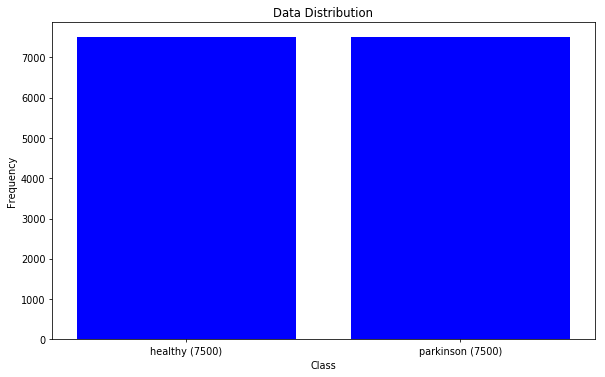

In [14]:
figure(figsize=(10, 6), dpi=70)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

## Visualizing the data:

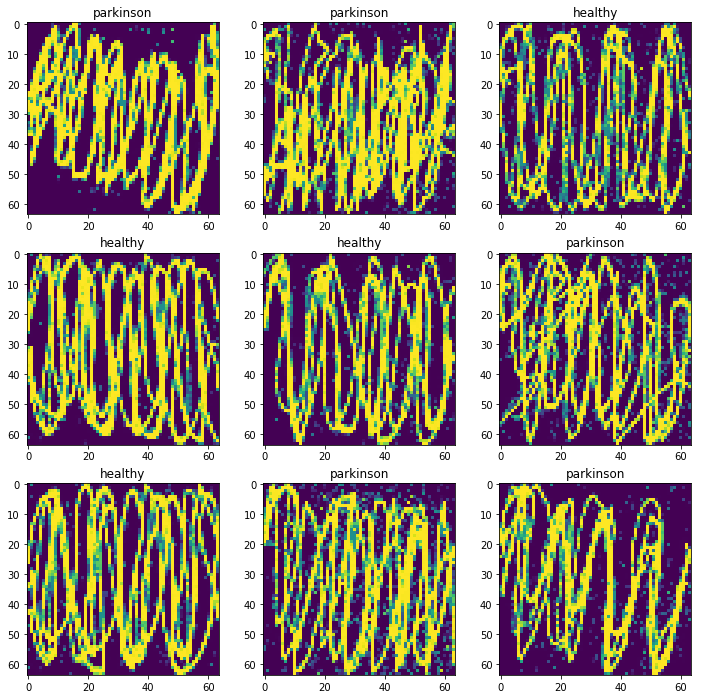

In [15]:
fig, axarr = plt.subplots(3,3)
fig_size = 12

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

num_images = 9

indecies = np.random.choice(range(len(overfit_dataset)), num_images)

# Retrieving the images:
images = []
labels = []

# Adding the images to an array to plot them:
for index in indecies:
    images.append(overfit_dataset[index][0])
    labels.append(overfit_dataset.rev_mapping[overfit_dataset[index][1]])
    
# Converting the images to numpy arrays so they can be plotted by matplotlib:
for ax, image, label in zip(axarr.flatten(), images, labels):
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    ax.set_title(label)
    ax.imshow(image.squeeze(), interpolation=None)

### Defining a sampler that samplers 100 images from each class:

In [16]:
# Getting the indecies of both classes (healthy, parkinson):
class_0_indecies = overfit_dataset.get_class_indecies(0)
class_1_indecies = overfit_dataset.get_class_indecies(1)

# Randomly sampling 100 images from each class:
class_0_indecies = np.random.choice(class_0_indecies, 100)
class_1_indecies = np.random.choice(class_0_indecies, 100)

# Creating the sampler:
inds = np.append(class_0_indecies, class_1_indecies)
sampler = SubsetRandomSampler(inds)

## Creating the data loader:

In [17]:
batch_size = 16
num_workers = 2

overfit_loader = DataLoader(dataset=overfit_dataset, batch_size=batch_size,
                            sampler=sampler, num_workers=num_workers,
                            pin_memory=True)

## Training the model:

### Defining the model:

In [18]:
overfit_model = Model()

### Defining the training routine:

In [19]:
# --- The optimizer ---------------------------------------------------
learning_rate = 1e-3
# Regularization weight (intensity):
weight_decay = 1e-5
optimizer = optim.Adam(overfit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# --- The loss function -----------------------------------------------
criterion = nn.CrossEntropyLoss()

### Number of epochs:

In [20]:
epochs = 5

# Start Training:

In [21]:
total_loss, train_accuracies, val_accuracies = train(model=overfit_model,
                                                    train_loader=overfit_loader,
                                                    validation_loader=overfit_loader,
                                                    optimizer=optimizer,
                                                    criterion=criterion,
                                                    epochs=epochs,
                                                    verbose=True)

100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Evaluating epoch...
Epoch: 0 | Train acc: 32.50% | Val acc: 32.50% | Loss: 11.1127 | Runtime: 28.90 seconds or 0.48 mins


100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Evaluating epoch...
Epoch: 1 | Train acc: 100.00% | Val acc: 100.00% | Loss: 0.9006 | Runtime: 1.94 seconds or 0.03 mins


100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


Evaluating epoch...
Epoch: 2 | Train acc: 100.00% | Val acc: 100.00% | Loss: 0.0000 | Runtime: 1.92 seconds or 0.03 mins


100%|██████████| 13/13 [00:01<00:00,  6.52it/s]


Evaluating epoch...
Epoch: 3 | Train acc: 100.00% | Val acc: 100.00% | Loss: 0.0000 | Runtime: 1.99 seconds or 0.03 mins


100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Evaluating epoch...
Epoch: 4 | Train acc: 100.00% | Val acc: 100.00% | Loss: 0.0000 | Runtime: 1.95 seconds or 0.03 mins


## Plotting the loss:

In [ ]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, 'bo-')
plt.plot(val_accuracies, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Plotting the training accuracy:

In [ ]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")

plt.ylabel("Loss Value")
plt.plot(total_loss, 'go-')

plt.show()

# ============================================================
# Setting up the actual model:

## Creating the dataset:

### Defining the dataset transforms:

In [23]:
# The image size all images will be resized to:
new_image_size = (128, 128)

In [24]:
# The following transform will:
#    1) Convert the input to torch.Tensor.
#    2) Convert the images to grayscale with one channel.
#    3) Resize the images to the value of the variable new_image_size.

transform = T.Compose([
                        T.ToTensor(),
                        T.Grayscale(num_output_channels=1),
                        T.Resize(new_image_size)
                        ])

In [25]:
# Creating the dataset with type='wave' which will load the wave images:
dataset = ParkinsonDataset(type='wave', transform=transform)

## Visualising the images after the transformation:

In [26]:
# Creating a plot with 9 subplots:
fig, axarr = plt.subplots(3,3)

# Setting the figure size:
fig_size = 12

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

num_images = 9

indecies = np.random.choice(range(len(dataset)), num_images)

# Retrieving the images:
images = []
labels = []

# Adding the images into an array to plot them:
for index in indecies:
    images.append(dataset[index][0])
    labels.append(dataset.rev_mapping[dataset[index][1]])
    
# Converting the images to numpy arrays so they can be plotted by matplotlib:
for ax, image, label in zip(axarr.flatten(), images, labels):
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    ax.set_title(label)
    ax.imshow(image.squeeze(), interpolation=None)

### Making the train, validation and test splits using samplers:

In [27]:
dataset_size = len(dataset)

# Defining the proportion of each split:
train_proportion = 0.6
val_proportion = 0.2
test_proportion = 0.2

# Defining the number of images each split will have:
train_split = math.floor(train_proportion * dataset_size)
val_split = math.floor(val_proportion * dataset_size)
test_split = math.floor(test_proportion * dataset_size)

# Creating the indecies and shuffling them. Those indecies
# will be used to create the samplers.
indecies = np.arange(dataset_size)
np.random.shuffle(indecies)

# Defining the indecies of the splits:
train_indecies = indecies[:train_split]
val_indecies = indecies[train_split : train_split + val_split]
test_indecies = indecies[train_split + val_split : train_split + val_split + test_split]

# Defining the samplers:
train_sampler = SubsetRandomSampler(train_indecies)
val_sampler = SubsetRandomSampler(val_indecies)
test_sampler = SubsetRandomSampler(test_indecies)

In [28]:
print(f'Number of training samples: {train_split}')
print(f'Number of validation samples: {val_split}')
print(f'Number of testsing samples: {test_split}')

Number of training samples: 9000
Number of validation samples: 3000
Number of testsing samples: 3000


## Plotting the data distribution:

In [29]:
data_dist = dataset.get_data_distribution()
data_dist

{'healthy': 7500, 'parkinson': 7500}

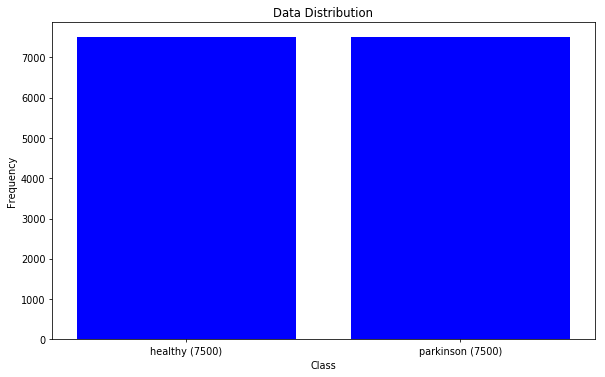

In [30]:
figure(figsize=(10, 6), dpi=70)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

### Creating the data loaders:

In [77]:
# Define the num_workers to the machine this model was trained on. Ideally, the num_workers should, at most, equal
# the number of cores the cpu has.
num_workers = 6

# Define the batch size for each split:
train_batch_size, val_batch_size, test_batch_size = 8, 8, 8

# Creating the data loaders for each split:
train_loader = DataLoader(dataset=dataset, sampler=train_sampler, batch_size=train_batch_size, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset, sampler=val_sampler, batch_size=val_batch_size, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset, sampler=test_sampler, batch_size=test_batch_size, pin_memory=True, num_workers=num_workers)

## Defining the model

In [78]:
model = Model(dropout_prob=0.5, image_dim=new_image_size)

## Defining the training routine:

In [79]:
# --- The optimizer ---------------------------------------------------
learning_rate = 8e-6
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

# --- The loss function -----------------------------------------------
criterion = nn.CrossEntropyLoss()

## Number of epochs:

In [80]:
epochs = 7

# Starting Training:

In [81]:
total_loss, train_accuracies, val_accuracies = train(model=model,
                                                    train_loader=train_loader,
                                                    validation_loader=val_loader,
                                                    optimizer=optimizer,
                                                    criterion=criterion,
                                                    epochs=epochs,
                                                    verbose=True)

100%|██████████| 1125/1125 [00:09<00:00, 112.90it/s]


Evaluating epoch...
Epoch: 0 | Train acc: 50.51% | Val acc: 49.87% | Loss: 555.3608 | Runtime: 9.97 seconds or 0.17 mins


100%|██████████| 1125/1125 [00:09<00:00, 114.06it/s]


Evaluating epoch...
Epoch: 1 | Train acc: 96.77% | Val acc: 97.60% | Loss: 254.4673 | Runtime: 9.86 seconds or 0.16 mins


100%|██████████| 1125/1125 [00:09<00:00, 114.58it/s]


Evaluating epoch...
Epoch: 2 | Train acc: 98.17% | Val acc: 98.60% | Loss: 146.2702 | Runtime: 9.82 seconds or 0.16 mins


100%|██████████| 1125/1125 [00:09<00:00, 114.13it/s]


Evaluating epoch...
Epoch: 3 | Train acc: 98.53% | Val acc: 98.57% | Loss: 106.0035 | Runtime: 9.86 seconds or 0.16 mins


100%|██████████| 1125/1125 [00:09<00:00, 113.89it/s]


Evaluating epoch...
Epoch: 4 | Train acc: 99.02% | Val acc: 99.33% | Loss: 83.0419 | Runtime: 9.88 seconds or 0.16 mins


100%|██████████| 1125/1125 [00:09<00:00, 114.35it/s]


Evaluating epoch...
Epoch: 5 | Train acc: 99.28% | Val acc: 99.40% | Loss: 68.1507 | Runtime: 9.84 seconds or 0.16 mins


100%|██████████| 1125/1125 [00:10<00:00, 110.44it/s]


Evaluating epoch...
Epoch: 6 | Train acc: 99.33% | Val acc: 99.33% | Loss: 57.6901 | Runtime: 10.19 seconds or 0.17 mins


## Plotting the train accuracy against the validation accuracy:

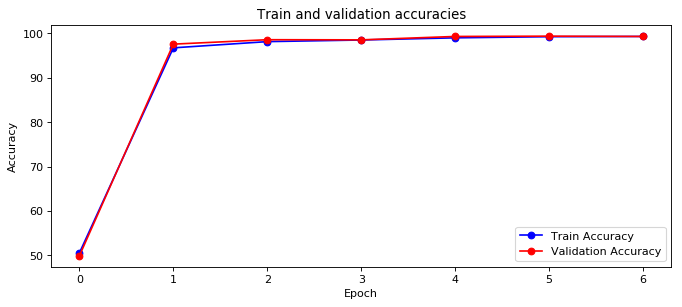

In [82]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, 'bo-')
plt.plot(val_accuracies, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Plotting the loss

In [83]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")

plt.ylabel("Loss Value")
plt.plot(total_loss, 'go-')

plt.show()

## Visualizing the filters:

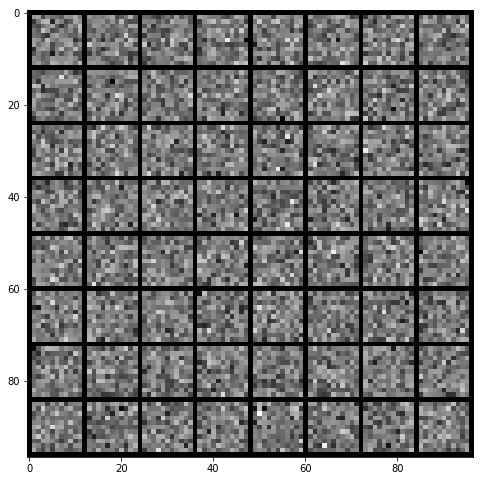

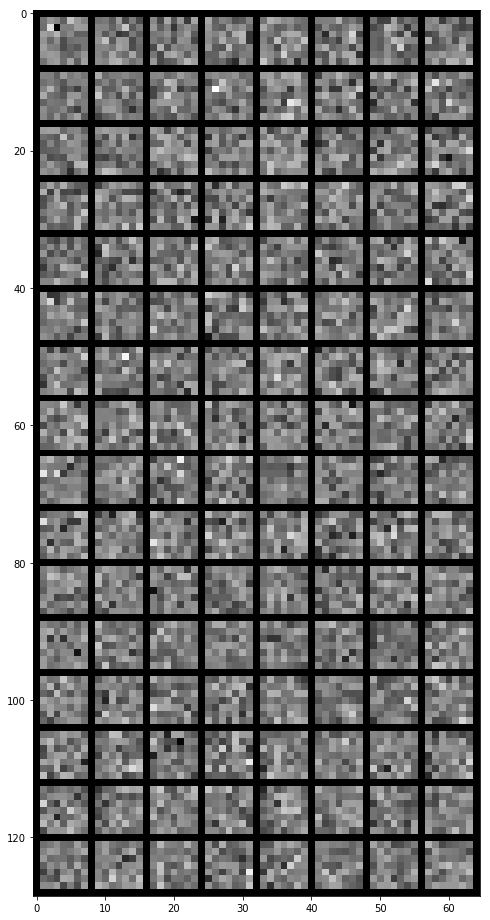

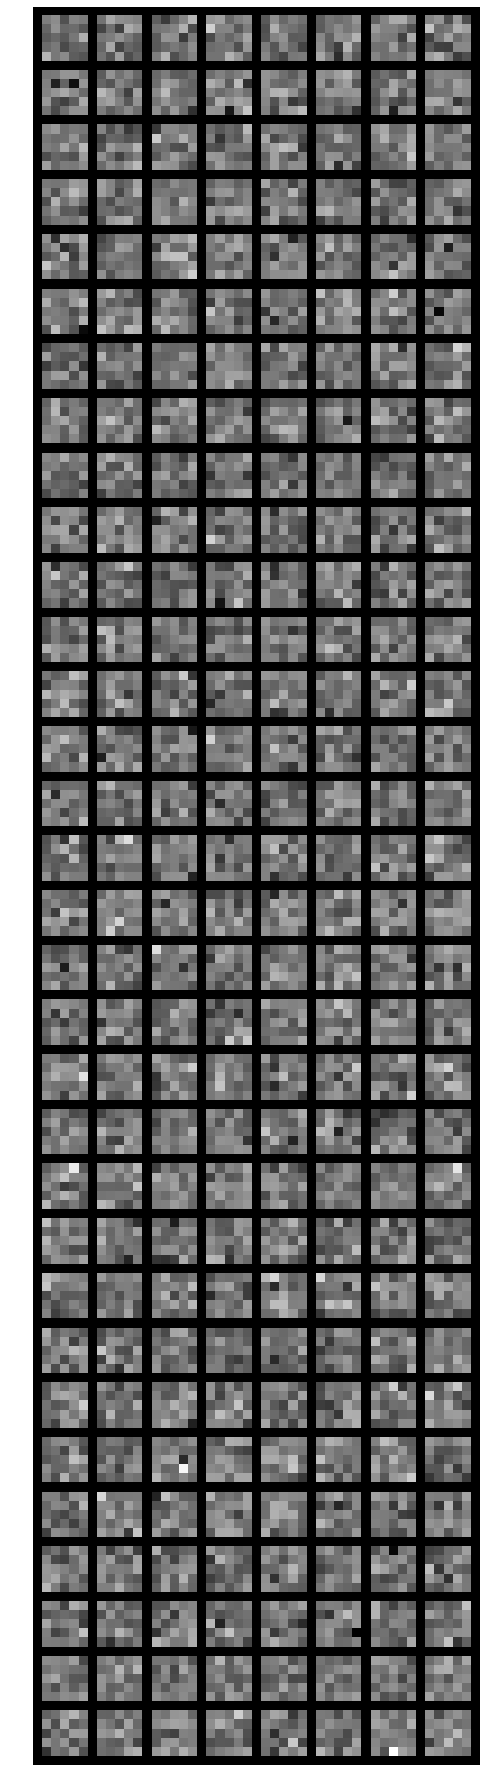

In [85]:
model.to('cpu')
filters = []
for layer in model.module_list:
    if isinstance(layer, nn.Conv2d):
        filter = layer.weight.data.clone()
        filters.append(filter)
        visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

## Convolving a random filter with a random image from the dataset:

In [115]:
f = filters[0]
index = random.randint(0, len(dataset))
rand_image, label = dataset[index][0], dataset[index][1]

# The label of the image to be convolved:
print(dataset.rev_mapping[label])

parkinson


### Visualizing the image to be convolved

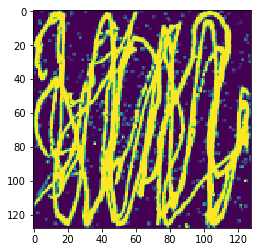

In [116]:
plt.imshow(np.transpose(rand_image.cpu().detach().numpy(), (1, 2, 0)).squeeze())

In [117]:
rand_image = rand_image.view(1, *rand_image.shape)

In [118]:
conv_im = nn.functional.conv2d(rand_image, f)

### Visualizing the convolved image:

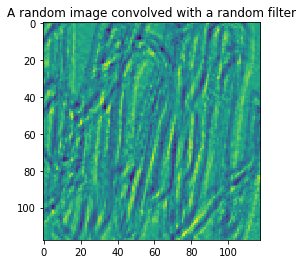

In [120]:
im1 = conv_im[:, 1, :, :].squeeze()
im1 = im1.cpu().detach().numpy()
plt.title('A random image convolved with a random filter')
plt.imshow(im1)

In [92]:
# Below is a code snipped that allows visualizing all the filters convolved with the image above.
# Uncomment the below code to show the images:

# height, width = 224, 2
# fig, axarr = plt.subplots(height, width)

# fig.tight_layout()
# fig_size = 256

# fig.set_figheight(fig_size)
# fig.set_figwidth(fig_size)

# conv_im = rand_image
# ind = 0
# for conv_num, f in enumerate(filters):
#     conv_im = nn.functional.conv2d(conv_im, f)
    
#     for i in range(f.shape[0]):
#         im = conv_im[:, i, :, :].squeeze()
#         im = im.cpu().detach().numpy()
        
#         ax = axarr.flatten()[ind]
#         ax.set_title(f'conv_{conv_num}')
#         ax.imshow(im)
#         ind += 1

## Visualizing some images from the test dataset and their predictions:

In [133]:
# Getting the indecies of the sample to test the model with:
test_inds = np.random.choice(test_indecies, 9)

# Create the sampler:
sampler = SubsetRandomSampler(test_inds)

# Creating a dataloader for the sampled images:
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=1)

In [134]:
preds = []
labels = []
images = []

# Getting the predictions from the model:
for x, y in loader:
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.float())
    
    _, pred = torch.max(y_pred, axis=1)
    
    # Appending the images, labels and predictions to their
    # corresponding lists:
    labels.append(dataset.rev_mapping[y.to('cpu').item()])
    images.append(x.to('cpu'))
    pred = pred.to('cpu')
    
    # Getting the text of the label (e.g. 0 -> healthy)
    preds.append(dataset.rev_mapping[pred.item()])    

## Plotting the predictions:

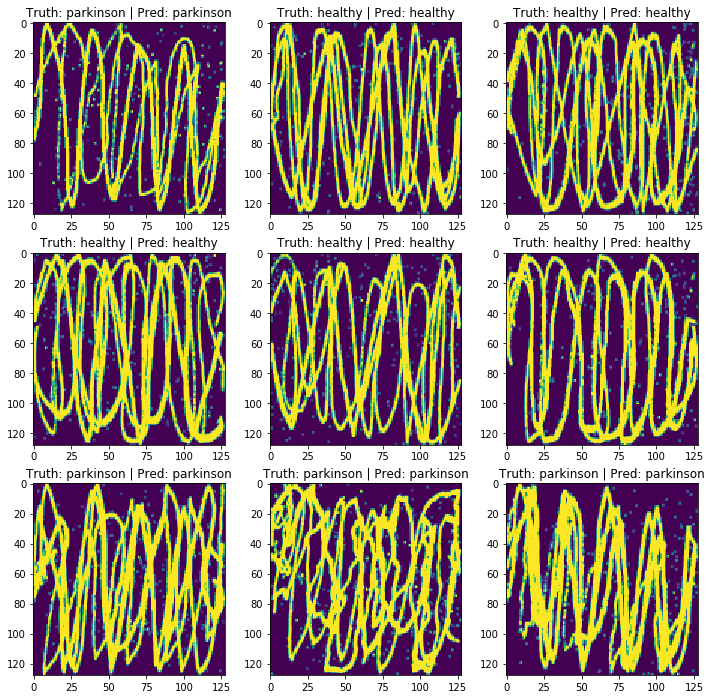

In [135]:
fig, axarr = plt.subplots(3, 3)

fig_size = 12

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

# Plotting the images with their ground truth and predictions as titles:
for ax, pred, label, image in zip(axarr.flatten(), preds, labels, images):
    image = image.cpu().detach().numpy()
    
    ax.set_title(f'Truth: {label} | Pred: {pred}')
    ax.imshow(image.squeeze())

# Evaluating the model with the test split:

In [97]:
test_accuracy = evaluate(model, test_loader)

In [98]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 99.17%


## Class accuracies:

In [99]:
classes = [dataset.rev_mapping[l] for l in np.unique(dataset.labels)]
class_accs = class_accuracies(model=model, data_loader=test_loader, class_names=classes)

for key, val in class_accs.items():
    print(f'{key}: {100 * val:.2f}%')

375it [00:01, 234.59it/s]

healthy: 99.66%
parkinson: 98.70%


# Test the model with spirals drawn on Paint:

In [126]:
# Define the path to the images' folder:
random_data_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'random_data', 'wave')
random_data_path

'E:\\Work_Longevity\\parkinsondiseasedetection\\random_data\\wave'

In [127]:
import glob
import cv2

# The paths of all the images:
im_paths = glob.glob(os.path.join(random_data_path, '*.png'))

In [128]:
images = []
labels = []

# Reading the images via OpenCV (cv2) and storing them in an array:
for im_path in im_paths:
    im = cv2.imread(im_path)
    
    labels.append(os.path.basename(im_path.split('.')[0]))
    
    im = transform_image(im, TRANSFORMS, TRANSFORMS_PARAMS)
    images.append(im)

## Plotting the images with their ground truths:

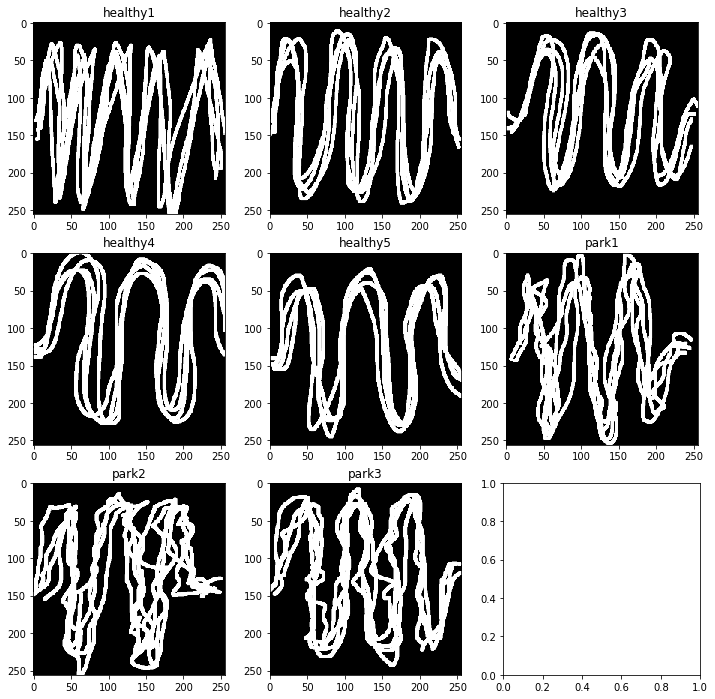

In [129]:
fig, axarr = plt.subplots(3, 3)

fig_size = 12

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)


for ax, image, label in zip(axarr.flatten(), images, labels):
    ax.imshow(image)
    ax.set_title(label)

## Generating predictions for the images:

In [130]:
preds = []

In [131]:
for image in images:
    image = transform(image)
    image = image.reshape((1, *image.shape))
    image = image.to(device)
    
    y_pred = model(image.float())
    
    _, label = torch.max(y_pred, axis=1)
    label = label.item()
    
    label = dataset.rev_mapping[label]
    preds.append(label)

## Plotting the images with their predictions:

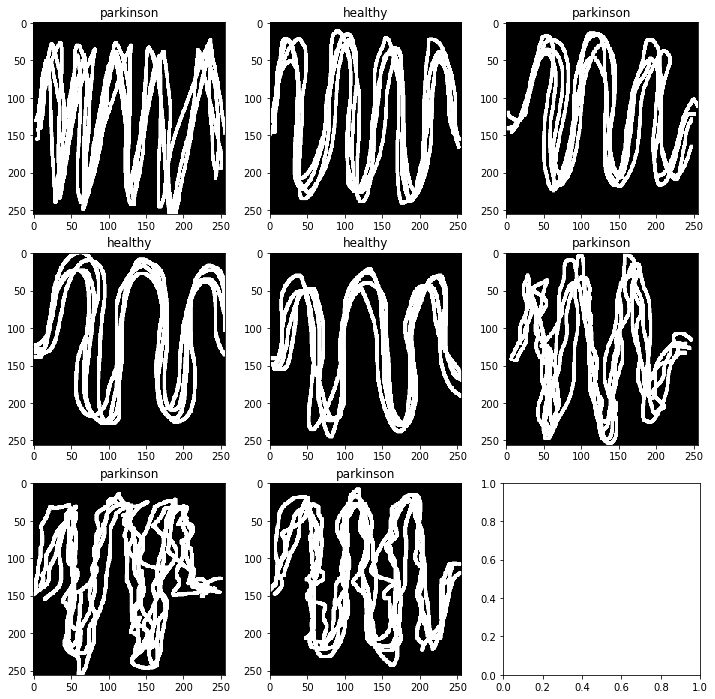

In [132]:
fig, axarr = plt.subplots(3, 3)

fig_size = 12

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

for ax, image, label in zip(axarr.flatten(), images, preds):
    ax.imshow(image)
    ax.set_title(label)

# Saving the model:

In [108]:
 # Creating the path of the model:
path = os.getcwd()
model_name = 'model_wave_v2'

MODEL_PATH = os.path.join(path, model_name)
MODEL_PATH

'E:\\Work_Longevity\\parkinsondiseasedetection\\model_wave_v2'

In [109]:
# Saving the model:
# torch.save(model.state_dict(), MODEL_PATH) 